# Load Libraries

In [109]:
library(repr)
options(repr.plot.width=10,repr.plot.height=7)
library(tidyverse)
theme_update(text = element_text(family = ""))

# Simulation Settings

In [30]:
# Fast but approximate solution under Sqrt assumptions
sig <- 0.01;
# Market volume
ADV <- 48000000;
# Volume to liquidate
n <- 480000;
t <- 24/390;
vavg <- n/(ADV*t+n);

In [31]:
# Instantaneous market impact functions
# LLOB approximation.
f_llob <- function(v, sigma = pi / 4) {
  # Sgima = pi/4 is an approximation.
  # sigma <- 0.785186408814605
  m <- log(pi)
  v <- abs(v)
  res <- sqrt(2 * v) * exp((-sqrt((log(v) - m)^2 + sigma^2) - m + log(v)) / 4)
  return(res)
}

In [32]:
# f <- function(v) {f_llob(v * 324) /18 }

#f <- function(v) { 0*f_barrier(v) + f_llob(v * 10e3) }
# f <- function(v) {v }
f <- f_llob

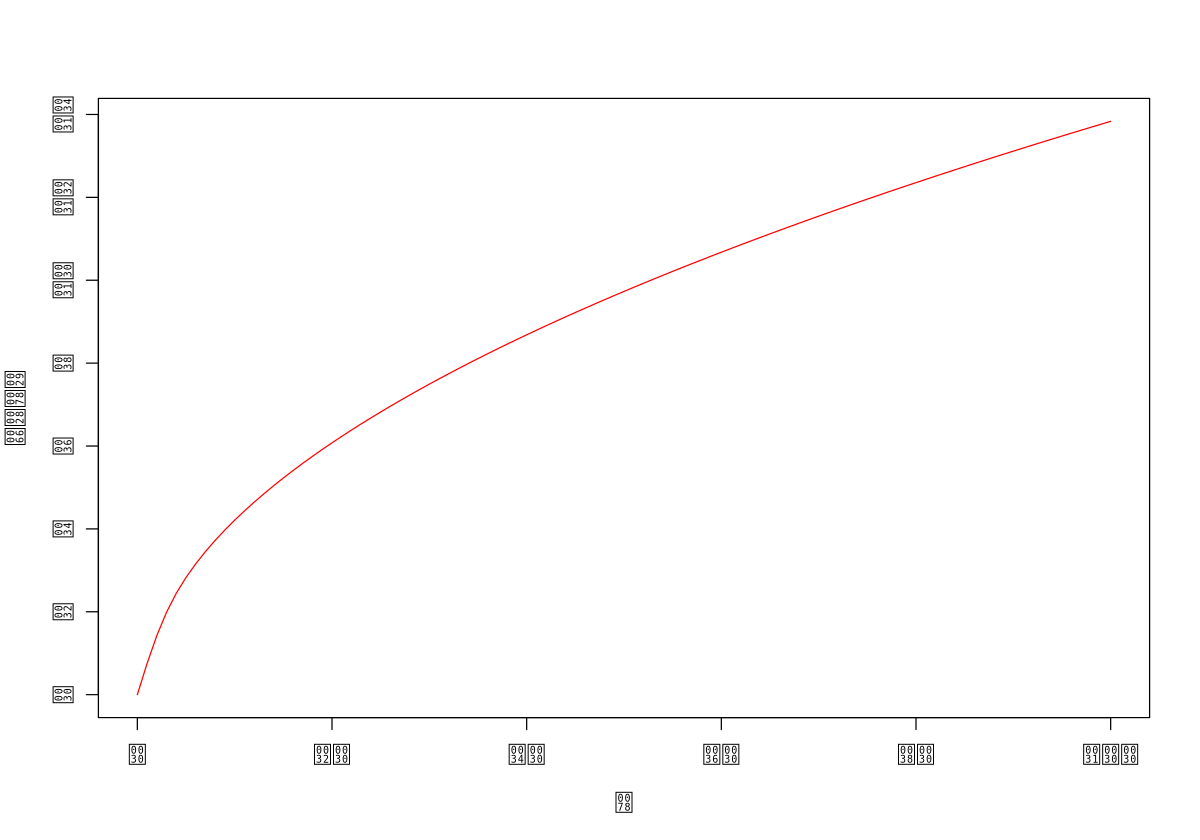

In [33]:
curve(f(x),from=0,to=100,col="red")

### Create a schedule with fixed times but variable quantities subject to total

In [34]:
# Generate an uneven schedule of interval VWAPs
schedule.U <- function(nShares, p.vec, T) {
    
    nSlices <- length(p.vec)  
    dT <- T/nSlices
  ti <- (1:nSlices) * dT
  vi <- p.vec*nShares/ADV
  fvi <- f(vi)
  sched.e <- data.frame(ti,p.vec*nShares,vi,fvi) 
     
sched <- rbind(c(0,0,0,0),sched.e)
  colnames(sched) <- c("Time", "nShrs", "volFrac","f_vi")
  return(sched)
}

In [35]:
# pj computes the impact of all prior executions on the price in the jth bucket (from t[j] to t[j+1))
pj <- function(t, v, fv, j) {
  pj <- fv[j] * sqrt(t[j + 1] - t[j]) # Self-interaction term
  if (j > 1) {
    for (i in 1:(j - 1))
    {
      decay <- ((t[j + 1] - t[i])^(3 / 2) - (t[j] - t[i])^(3 / 2) - (t[j + 1] - t[i + 1])^(3 / 2) + (t[j] - t[i + 1])^(3 / 2)) / (t[j + 1] - t[j])
      pj <- pj + decay * fv[i]
    }
  }
  return(pj)
}

In [36]:
# Finally, the function that costs a particular schedule
costSchedule <- function(sched) {
  tt <- sched[, 1] # Remember that first element is t=0!
  m <- length(tt)
  dt <- diff(tt)
  nn <- sched[, 2][2:m]
  v <- nn / (ADV * dt + nn*0) # Volume fractions include own volume in denominator!
  ff <- function(vv) {
    f(vv)
  }
  fv <- as.numeric(lapply(v, ff))
  cost <- 0
  for (j in 1:(m - 1)) {
    cost <- cost + nn[j] * pj(tt, v, fv, j)
  }
  return(cost * sig / n)
}

In [37]:
obj <- function(nShares,T)function(p.vec){
    
    p.vec2 <- p.vec/sum(p.vec)
    #print(p.vec2)
    costSchedule(schedule.U(nShares,p.vec2, T))
}

In [38]:
obj(n,.5)(p.vec=c(100,rep(0,11)))

[1] 0.0003795905

In [39]:
p.vec <- c(100,rep(0,19))

In [40]:
(res.optim <- optim(p.vec,obj(n,.5),method="L-BFGS-B",lower=rep(0,length(p.vec)),upper=rep(1,length(p.vec))))

$par
 [1] 0.3052893 0.2061952 0.1882281 0.1747744 0.1676835 0.1616309 0.1568868
 [8] 0.1534491 0.1512103 0.1500337 0.1498037 0.1504583 0.1520143 0.1545959
[15] 0.1584768 0.1641544 0.1725019 0.1851778 0.2037068 0.3018372

$value
[1] 0.0001094889

$counts
function gradient 
      13       13 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

In [41]:
sum(res.optim$par)

[1] 3.608108

In [42]:
# Finally, finally, a function to compute the optimal strategy given theta (the characteristic timescale)
optimaUnevenStrategy <- function(nShares,T)function(p.vec) {

    p.l <- length(p.vec)
    res <- optim(p.vec,obj(nShares,T),method="L-BFGS-B",lower=rep(0,p.l),upper=rep(1,p.l))
    return(list(cost=res$value,p=res$par/sum(res$par)))
}

## Low participation rates

We should recover Schid's bucket-shape profile.

In [69]:
p.vec <- c(1,rep(0,50))

In [70]:
res.opt <- optimaUnevenStrategy(nShares=n,T=1)(p.vec)

In [71]:
res.opt$cost

[1] 7.746709e-05

In [72]:
opt.theo <- function(p.vec){
    p.l <- length(p.vec)
    s.e <- (1:p.l)/p.l
    s.b <- (0:(p.l-1))/p.l
    s <- (s.b+s.e)/2
    sched.raw <- 1/(s*(1-s))^(1/4)
    sched <- sched.raw/sum(sched.raw)
    return(sched)
}

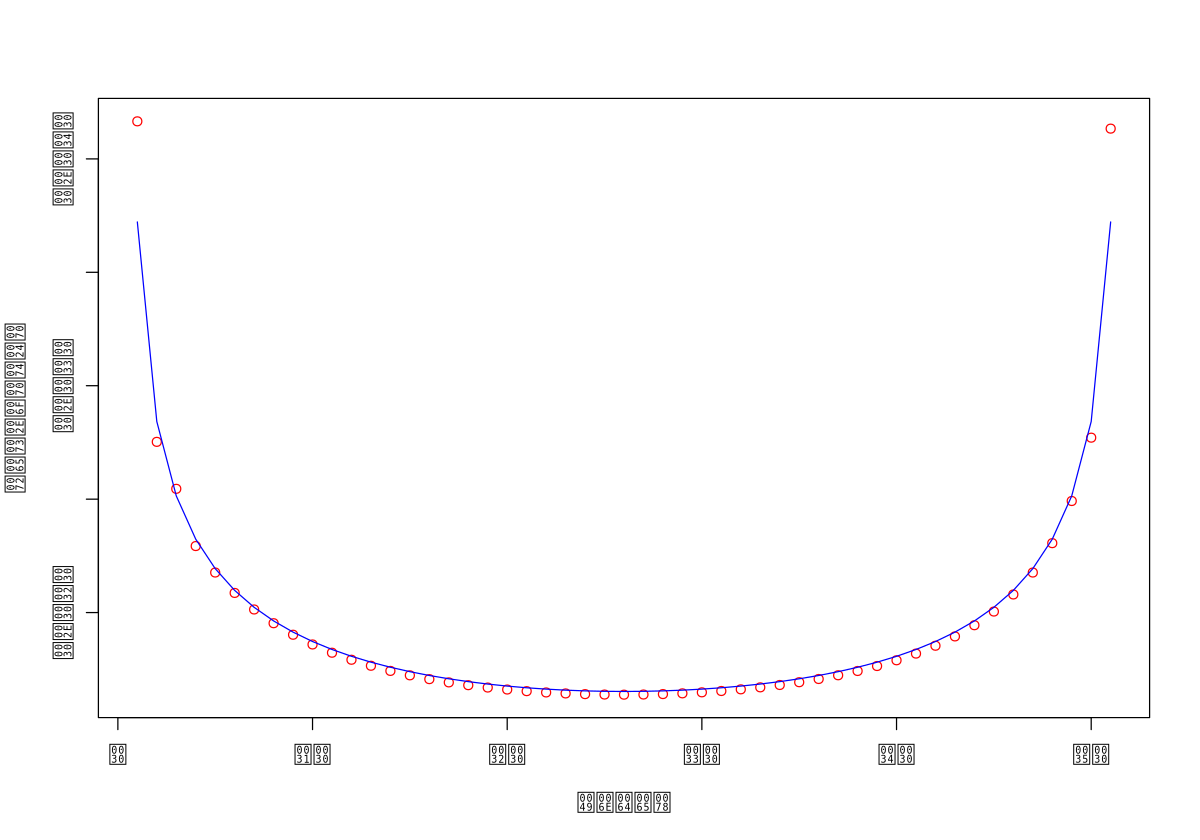

In [73]:
plot(res.opt$p,col="red",pch=1)
lines(1:length(p.vec),opt.theo(p.vec),col="blue")

In [86]:
num_sol <- c(4.357267802271693,1.7949720237004305,1.276581472943459,1.0448404846579813,0.9357857600090426,0.8662433066542193,0.8338421241101671,0.8028691290559531,0.7868956258189372,0.7744747452858789,0.7647868202257471,0.7571951491925137,0.7512304132186933,0.7465474735886684,0.7428938404782485,0.7400808490280313,0.7379717670014183,0.736466653388776,0.7354935223490829,0.7350022603819879,0.73496033319231,0.7353490001156285,0.7361612023353251,0.7374008157596105,0.7390811778570637,0.7412250672463587,0.7438649023840495,0.7470433574708714,0.7508155345901311,0.7552461118412243,0.7604196805536206,0.7664347758119548,0.773412961089977,0.7814986778464094,0.7908660061099454,0.8017222249575917,0.8143102814859255,0.8289086929017471,0.8458227732937648,0.8653518233716784,0.8876948981378334,0.9126708848066928,0.9390803692475406,0.9072044154277069,0.9066132903446067,1.0364008208448254,1.0338606766887333,0.9744872488299449,0.8829984190238778,5.147652353072125,5.147652353072125)

In [87]:
length(res.opt$p)

[1] 51

In [115]:
schedule = tibble(
    t = seq(0.001, 1 - 0.001, length.out = length(res.opt$p)),
    propagator = res.opt$p * length(res.opt$p) / sum(res.opt$p),
    numerical = num_sol,
    expected = (t*(1-t))^(-1/4),
) %>% mutate(
    expected = expected * length(expected) / sum(expected)
) %>% pivot_longer(c(propagator, numerical, expected), names_to = "method", values_to = "eta")

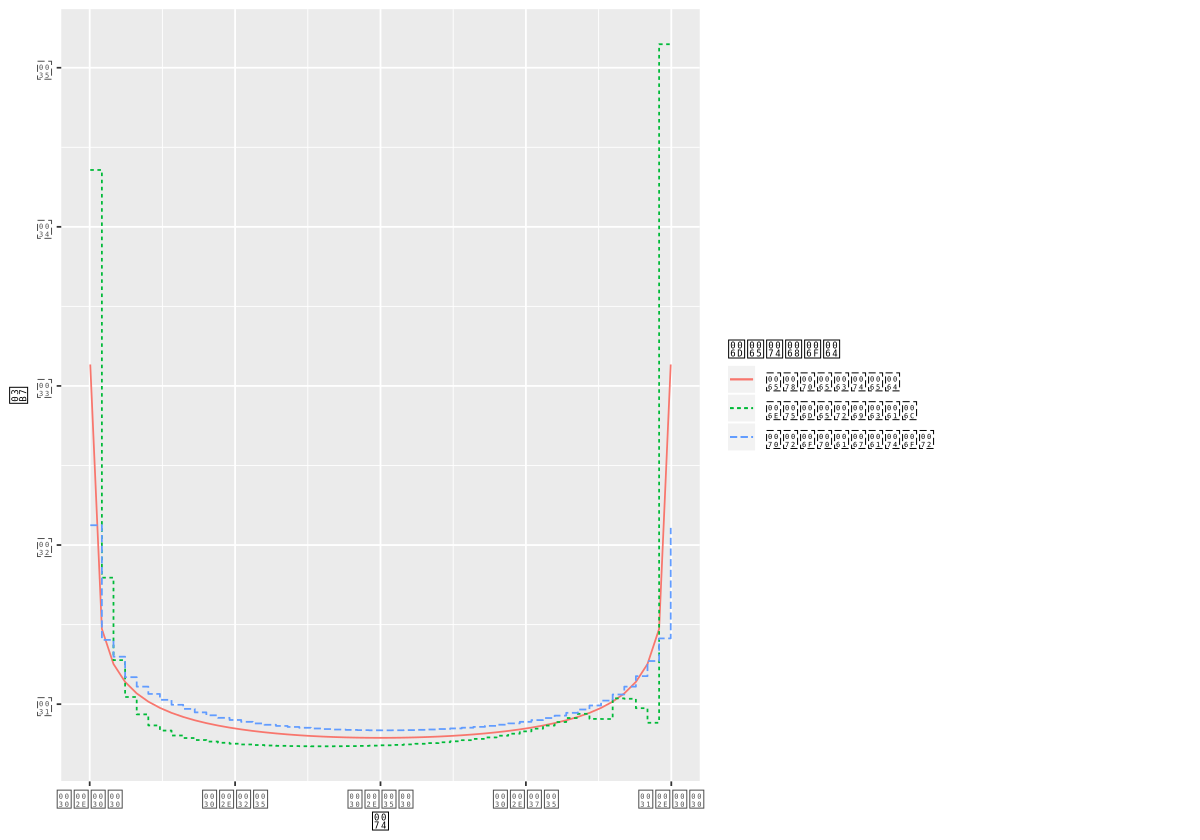

In [127]:
p <- ggplot(aes(x = t, y = eta, color = method, linetype = method), data = schedule) +
    geom_line(data = filter(schedule, method == "expected")) +
    geom_step(data = filter(schedule, method != "expected")) +
    ylab(expression(eta))
show(p)

In [128]:
ggsave("./low_rate.pdf", p)

Saving 6.67 x 6.67 in image


## High Total Volume

We expect to see chunking as $n$ increases.

This behavior is most obvious when liquidation volume $n$ approaches $ADV$.

In [133]:
p.vec <- c(1,rep(0,99))
n <- ADV * sig

In [134]:
res.opt <- optimaUnevenStrategy(nShares=n * 100,T=.5)(p.vec)

In [135]:
res.opt$cost

[1] 0.6986152

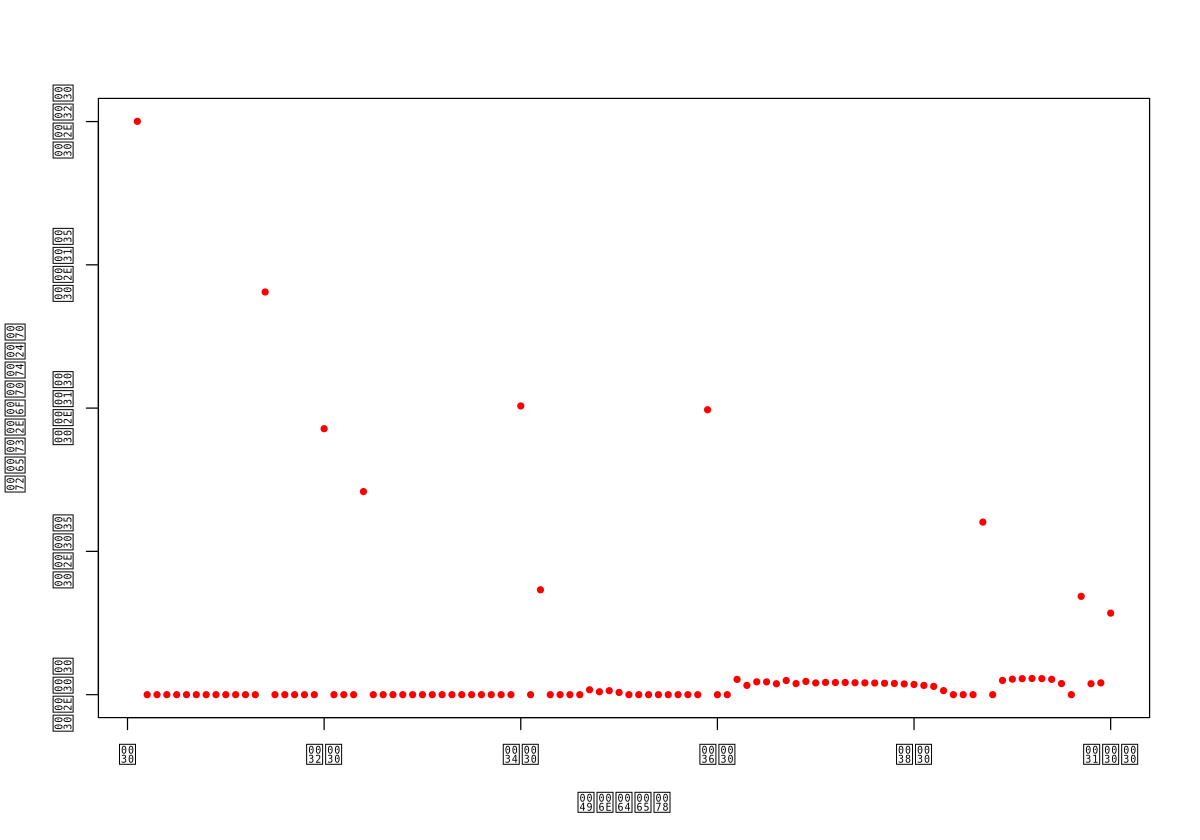

In [137]:
plot(res.opt$p,col="red",pch=20)

In [140]:
schedule_high = tibble(
    t = seq(0.001, 1 - 0.001, length.out = length(res.opt$p)),
    eta = res.opt$p * length(res.opt$p) / sum(res.opt$p) * 100,
)

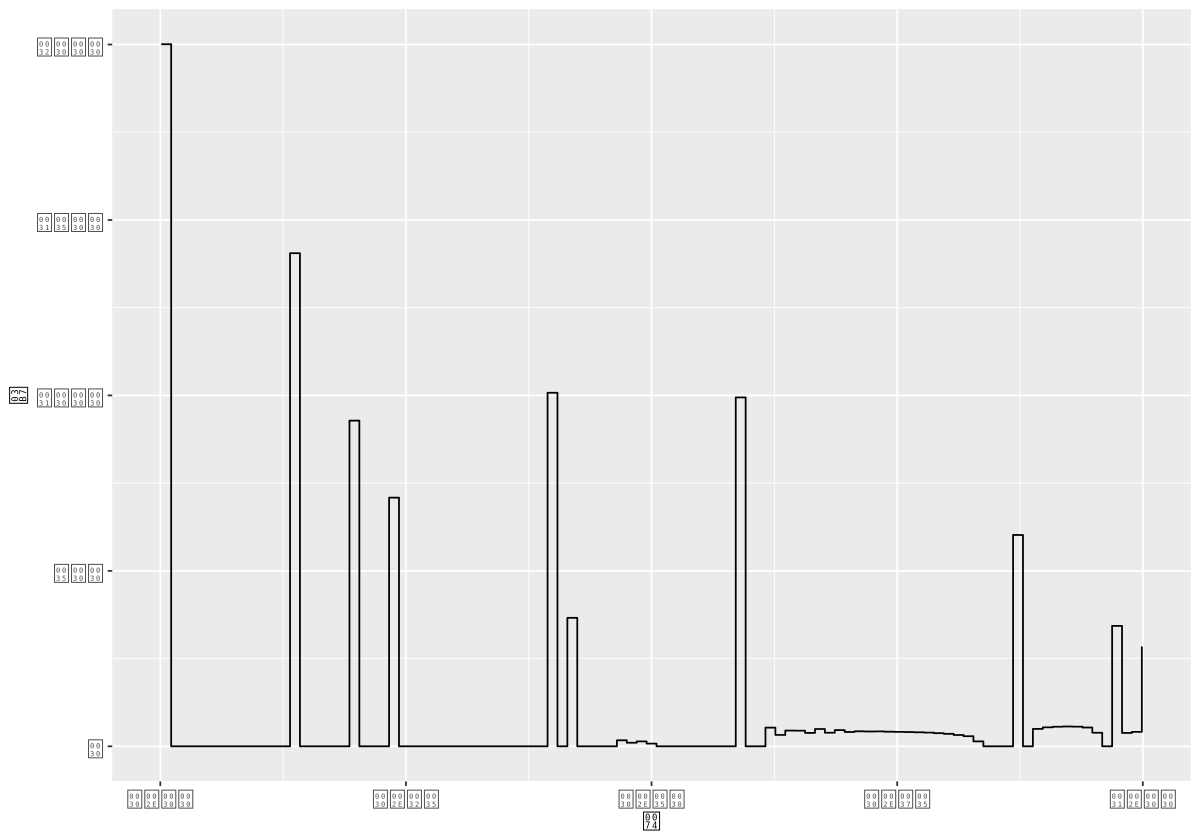

In [141]:
p <- ggplot(aes(x = t, y = eta), data = schedule_high) +
    geom_step() +
    ylab(expression(eta))
show(p)

In [142]:
ggsave("./high_strat.pdf", p)

Saving 6.67 x 6.67 in image


In [26]:
for (m in res.opt$p) {
    print(m)
}

[1] 0.2000809
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0.1405311
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0.09281809
[1] 0
[1] 0
[1] 0
[1] 0.07087044
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0.1007506
[1] 0
[1] 0.03660915
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0.001708684
[1] 0.001017543
[1] 0.001397463
[1] 0.0007735012
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0.09943178
[1] 0
[1] 0
[1] 0.005327777
[1] 0.003243534
[1] 0.004482769
[1] 0.004455653
[1] 0.003818174
[1] 0.004933891
[1] 0.003867007
[1] 0.004617562
[1] 0.004089368
[1] 0.004276473
[1] 0.004226324
[1] 0.004247665
[1] 0.004164468
[1] 0.004115296
[1] 0.004065114
[1] 0.003991986
[1] 0.00390602
[1] 0.003748839
[1] 0.003560223
[1] 0.003225596
[1] 0.002882665
[1] 0.001412195
[1] 0
[1] 0
[1] 0
[1] 0.06022491
[1] 0
[1] 0.004963018
[1] 0.0054073
[1] 0.005577338
[1] 0.005648668
[1] 0.005600122
[1] 0.00535657
[1] 0.003870081
[1] 0
[1] 0.03431605
[1] 0.0038173

In [27]:
p.vec <- c(1,rep(0,99))
n <- ADV * sig

In [28]:
res.opt <- optimaUnevenStrategy(nShares=n * 100,T=.5)(p.vec)

In [ ]:
res.opt$cost

In [ ]:
plot(res.opt$p,col="red",pch=20)

In [ ]:
p.vec <- c(1,rep(0,199))
n <- ADV * sig

In [ ]:
res.opt <- optimaUnevenStrategy(nShares=n * 100,T=.5)(p.vec)

In [ ]:
res.opt$cost

In [ ]:
plot(res.opt$p,col="red",pch=20)

# Low Volume w/ Penalty on Participation Rates

See if the same effect can be achieved with a lower total volume but a penalty on participation rate (a cap).

In [ ]:
rate_barrier <- function(barrier, p.vec) {
    min(sum(-log(sapply(barrier-p.vec, function(x) {max(x, 1e-1000)}))), 1e10)
}

# alpha is penality level.
obj_cap <- function(nShares,T, alpha, rate_cap)function(p.vec){
    p.vec2 <- p.vec/sum(p.vec)
    sched <- schedule.U(nShares,p.vec2, T)
    costSchedule(sched) + alpha * rate_barrier(rate_cap, sched$volFrac)
}

In [ ]:
obj_cap(n, 0.5, 0.0, 0.5)(p.vec)
obj_cap(n, 0.5, 1e-6, 0.5)(p.vec)
obj_cap(n, 0.5, 1e-7, 0.02)(p.vec)
obj_cap(n, 0.5, 1e-7, 0.011)(p.vec)
obj_cap(n, 0.5, 1e-7, 0.01)(p.vec)

In [ ]:
optimaUnevenStrategyRateLimited <- function(nShares,T,alpha, rate_cap)function(p.vec) {
    p.l <- length(p.vec)
    res <- optim(p.vec,obj_cap(nShares,T, alpha, rate_cap),method="L-BFGS-B",lower=rep(0,p.l),upper=rep(1,p.l))
    return(list(cost=res$value,p=res$par/sum(res$par)))
}

In [ ]:
n <- ADV * sig

In [ ]:
p.vec <- c(rep(0.01,200))
res.opt <- optimaUnevenStrategyRateLimited(nShares=n*50,T=.5, alpha=1e-7, rate_cap=0.006)(p.vec)
plot(res.opt$p,col="red",pch=20)

In [ ]:
p.vec <- c(rep(0.01,200))
res.opt <- optimaUnevenStrategyRateLimited(nShares=n*100,T=.5, alpha=1e-7, rate_cap=0.015)(p.vec)
plot(res.opt$p,col="red",pch=20)

In [ ]:
obj_cap_print <- function(nShares,T, alpha, rate_cap)function(p.vec){
    p.vec2 <- p.vec/sum(p.vec)
    sched <- schedule.U(nShares,p.vec2, T)
    sched
}
ss <- obj_cap_print(n * 100, 0.5, 0.0, 0.002)(res.opt$p)

In [ ]:
ss